 To run all the examples in this page you need the following packages:

In [1]:
using Kinbiont
using CSV
using Plots
using Distributions
using Optimization
using OptimizationNLopt
using NLopt
using Tables
using Random
using KinbiontPlots
using Catalyst


## Fitting a single kinetics

### Simulating Data with ODEs

First we simulate the data to use them as example for the fitting:

In [51]:
model = "triple_piecewise_adjusted_logistic"
n_start = [0.1]
tstart = 0.0
tmax = 500.0
delta_t = 15.0


param_of_ode = [0.06, 1.0, 200, 0.5, 0.001, 450, -0.0002]

7-element Vector{Float64}:
   0.06
   1.0
 200.0
   0.5
   0.001
 450.0
  -0.0002

Them we call the Kinbiont.jl API to simulate data used in the following examples:

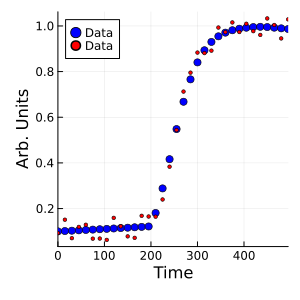

In [52]:
sim = Kinbiont.ODE_sim(model, n_start, tstart, tmax, delta_t, param_of_ode)

# Plotting scatterplot of data 
Plots.scatter(sim, xlabel="Time", ylabel="Arb. Units", label=["Data " nothing], color=:blue, size=(300, 300))

#adding uniform random noise
noise_unifom = rand(Uniform(-0.05,0.05),length(sim.t))


data_t = reduce(hcat,sim.t)
data_o = reduce(hcat,sim.u)
data_OD = vcat(data_t,data_o)
data_OD[2,:] = data_OD[2,:] .+ noise_unifom
# ploting scatterplot of data with noise

Plots.scatter!(data_OD[1,:],data_OD[2,:], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],color=:red,markersize =2 ,size = (300,300))

When data are store in a Matrix of Float64 with 2 rows it is possible to perfor various analyses

In [53]:
data_OD

2×34 Matrix{Float64}:
 0.0        15.0       30.0        …  465.0      480.0       495.0
 0.0927422   0.151141   0.0701637       1.00422    0.945254    1.0287

### Evaluation of the dynamics of specific growth rate
The user can evaluate   of the specific growth rate  during all the curve. This can be done by running the following:

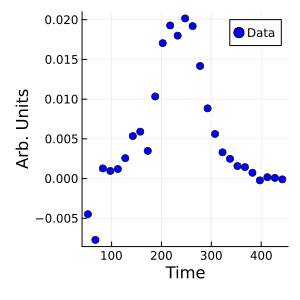

In [54]:
pt_win = 7
specific_gr_array = Kinbiont.specific_gr_evaluation(data_OD,pt_win )
specific_gr_times = [
    (data_OD[1, r] + data_OD[1, 	(r+pt_win)]) / 2 for
    r = 1:1:(eachindex(data_OD[2, :])[end].- pt_win)
 	]
Plots.scatter(specific_gr_times,specific_gr_array, xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],  color=:blue, size = (300,300))

### Log-Lin fitting

To perform the log-linear fitting  (of data generated in the previous examples) it is suffucient to run. 

In [55]:
res_log_lin = Kinbiont.fitting_one_well_Log_Lin(
    data_OD, # dataset first row times second row OD
   "test", # name of the well
    "test log-lin fitting"; #label of the experiment
    type_of_smoothing="rolling_avg", # type of smoothing
    pt_avg=7, # number of the point for rolling avg not used in the other cases
    pt_smoothing_derivative=7, # number of poits to smooth the derivative
    pt_min_size_of_win=7, # minimum size of the exp windows in number of smooted points
);

 The results are stored in the ```res_log_lin```  data struct. 
 for example in the second position you can find the parameters of the fit (see documentation for the order)
 

In [56]:
 res_log_lin[2]
 

14-element Vector{Any}:
    "test log-lin fitting"
    "test"
 135.0
 225.0
 232.5
   0.016999635628122522
   0.01269743153611869
   0.0014412673456435183
  54.5895584148843
  61.57934166831699
  49.024820908665774
  -4.075553841148158
   0.263006610186683
   0.9692666870809171

Before fitting, the model, the initial guess of parameters for the optimization and upper and lower bounds for the ODE parameters are defined :
 

In [57]:
model ="aHPM"

p_guess = [0.01, 0.001, 1.00, 1]
ub_ahpm = p_guess.*4
lb_ahpm = p_guess./4

4-element Vector{Float64}:
 0.0025
 0.00025
 0.25
 0.25

The actual fitting is accomplished through the ```fitting_one_well_ODE_constrained``` function.  In this case wed do not use the lb and ub they will be generated automatically.

┌ Warning: The used optimization method requires box bounds, Kinbiont.jl will use upper bounds that are 10 times the guess
│              and lower bounds that are 10 times lower the guess.
│              This choice can be suboptimal. Note that the Kinbiont.jl default optimizer requires box bounds to guaranteed a Real N(t) and positive parameters.
│              To avoid to specify the bounds use you can use an optimizer that do not require it, e.g., `optimizer = NOMADOpt()`. 
│              Note that numerical instabilities may occur.
│              
└ @ Kinbiont C:\Users\fabri\.julia\packages\Kinbiont\JBDLc\src\functions.jl:916


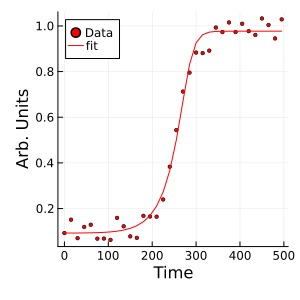

In [58]:
# Performing ODE fitting
results_ODE_fit = Kinbiont.fitting_one_well_ODE_constrained(
    data_OD, 
    "test",
    "test_ODE",
    model,
    p_guess;
)
Plots.scatter(data_OD[1,:],data_OD[2,:], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],color=:red,markersize =2 ,size = (300,300))
Plots.plot!(results_ODE_fit[4],results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=["fit " nothing],color=:red,markersize =2 ,size = (300,300))

To add lower and upper bounds one should use the ```opt_params...``` keyword argument:

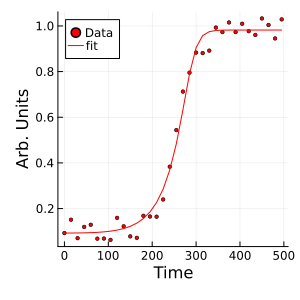

In [59]:
# Performing ODE fitting

results_ODE_fit = Kinbiont.fitting_one_well_ODE_constrained(
    data_OD, 
    "test",
    "test_ODE",
    model,
    p_guess;
   lb = lb_ahpm,
   ub = ub_ahpm
)

Plots.scatter(data_OD[1,:],data_OD[2,:], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],color=:red,markersize =2 ,size = (300,300))
Plots.plot!(results_ODE_fit[4],results_ODE_fit[3], xlabel="Time", ylabel="Arb. Units", label=["fit " nothing],color=:red,markersize =2 ,size = (300,300))

To change the optimization method one should call the desired library from Optimization.jl and use the keyword argument ```optimizer``` and if required by the selected optimizer it necessary to specify the differentiation methods, e.g.:

- using PRAXIS algorithm, with Tik-Tak restart (from Benchmarking global optimizers, Arnoud et al 2019)

In [60]:
results_ODE_fit = Kinbiont.fitting_one_well_ODE_constrained(
    data_OD, 
    "test",
    "test_ODE",
    model,
    p_guess;
   lb = lb_ahpm,
   ub = ub_ahpm,
   optimizer=NLopt.LN_PRAXIS(), 
       multistart = true,
)

("ODE", Any["test_ODE", "test", "aHPM", 0.02367716538891904, 0.00025000000021985734, 0.9821145997522502, 3.9999999741984684, 0.016495753953421673, 0.020160663791835388, 0.026146000948448305], [0.09274222209188956, 0.09281190015719237, 0.09305903050342701, 0.09355871908642328, 0.09441808202828589, 0.09578991992597773, 0.09789225256360184, 0.10103560948032982, 0.10566403345851721, 0.11240828025187194  …  0.9815938811499072, 0.9819411501561263, 0.9820632060772105, 0.9821061381175483, 0.9821101853223244, 0.9821115887953962, 0.9821303508068445, 0.9820997824902109, 0.9821074844840993, 0.9821119327120854], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0])

- Changing the number of iterations and absolute tolerance:

In [61]:
results_ODE_fit = Kinbiont.fitting_one_well_ODE_constrained(
    data_OD, 
    "test",
    "test_ODE",
    model,
    p_guess;
   lb = lb_ahpm,
   ub = ub_ahpm,
   abstol = 0.0001,
   maxiters= 20000,
)

("ODE", Any["test_ODE", "test", "aHPM", 0.025899046852745963, 0.0002518793027043513, 1.020190088595604, 1.512043603234446, 0.014517468016940246, 0.020160663791835388, 0.02835691811295671], [0.09274222209188956, 0.0928175826984873, 0.09308799255423916, 0.0936423647313371, 0.09461021284738075, 0.09617994463951696, 0.09862534362847315, 0.10234235843740498, 0.10790221812967693, 0.11612261426441538  …  0.9887094689828728, 1.0013700481034122, 1.009188237809505, 1.0136290409970496, 1.0163762173275293, 1.0179886240250267, 1.0188467007926827, 1.0194042959880774, 1.019733261009441, 1.0199182273959568], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0])

###   Custom ODE Fitting

Using the custom ODE fitting, users can fit any ordinary differential equation. First it is necessary to define the differential equation. This is done by declaring a new function, e.g.:

In [62]:
# Custom ODE function
function ODE_custom(du, u, param, t)
    du[1] = u[1] * (1 - u[1]) * param[2] + param[1] * u[1]
end

ODE_custom (generic function with 1 method)

Now, we set upper and lower bounds of the parameters of the ODE:

In [63]:
custom_ub = [1.2, 1.1]
custom_lb = [0.0001, 0.00000001]
param_guess = custom_lb .+ (custom_ub.-custom_lb)./2


2-element Vector{Float64}:
 0.60005
 0.5500000050000001

Finally, we perform the fit:

In [64]:
# Performing custom ODE fitting
results_ODE_fit = Kinbiont.fitting_one_well_custom_ODE(
    data_OD, # dataset first row times second row OD
   "test", # name of the well
    "test custom ode", #label of the experiment
   ODE_custom, #  model to use
   param_guess,
    1; # number  in the system
  )

┌ Warning: The used optimization method requires box bounds, Kinbiont.jl will use upper bounds that are 10 times the guess
│              and lower bounds that are 10 times lower the guess.
│              This choice can be suboptimal. Note that the Kinbiont.jl default optimizer requires box bounds to guaranteed a Real N(t) and positive parameters.
│              To avoid to specify the bounds use you can use an optimizer that do not require it, e.g., `optimizer = NOMADOpt()`. 
│              Note that numerical instabilities may occur.
│              
└ @ Kinbiont C:\Users\fabri\.julia\packages\Kinbiont\JBDLc\src\functions.jl:916


("custom_ODE", Any["test", "custom_model", [0.06000500000000123, 5.50000004999974], 0.15924248920020742, 0.06209721937520461, 0.1825038912996408], [0.09274222209188956, 1.0107634113323616, 1.0108351161240283, 1.0109067703678014, 1.0109753271149726, 1.0110367498496187, 1.0110877409158534, 1.0111257378371141, 1.011148915000838, 1.0111561823222086  …  1.0107913217543087, 1.010862557057378, 1.0109335533258155, 1.0109998218828407, 1.0110576099170858, 1.0111039007270086, 1.011136413677793, 1.0111536034985351, 1.0111546614564615, 1.0108379836995867], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0])

###   ODE Sensitivity Analysis

The sensitivity analysis is performed with the ```one_well_morris_sensitivity``` function. This function takes a preprocessed time series (```data_OD```), the name and label of the well, the ODE model to use ("aHPM" in this case), as well as the lower and upper bounds for the ODE parameters. The number of steps in the Morris method (```n_step_sensitivity```) should be specified.

In [65]:
# Number of steps for Morris sensitivity analysis
n_step_sensitivity = 5
p_guess = [0.01, 0.001, 1.00, 1]
ub_ahpm = p_guess.*5
lb_ahpm = p_guess./5
# Performing Morris sensitivity analysis
sensitivity_test = Kinbiont.one_well_morris_sensitivity(
    data_OD, 
    "test",
     "test_sensitivity",
      "aHPM", 
      lb_ahpm,
       ub_ahpm,
    N_step_morris=n_step_sensitivity ;
)

("ODE_Morris_sensitivity", Any["label_exp" "test_sensitivity" … "test_sensitivity" "test_sensitivity"; "well" "test" … "test" "test"; … ; "emp_max_gr" 0.020160663791835388 … 0.020160663791835388 0.020160663791835388; "loss" 0.025867458983333792 … 0.02586745898310447 0.025867458983104188], [0.002 0.01 … 0.042 0.042; 0.0002 0.0002 … 0.0042 0.0042; 0.2 0.2 … 4.199999999999999 4.199999999999999; 0.2 0.2 … 3.3999999999999995 4.199999999999999])

###   ODE Model Selection

The user can use the model selection function to use AIC (or AICc) to identify the best model to fit a specific kinetics.
We start defining the list of the models and the upper and lower bounds of the parameters:

In [66]:
# Models candidates and their parameter bounds
list_of_models = ["aHPM",   "baranyi_roberts"]
ub_1 =[ 0.1 , 0.1 , 0.1 , 5.001    ]
lb_1 =[ 0.0001 , 0.001,0.0  , 0.001 ]
p1_guess = lb_1 .+ (ub_1.-lb_1)./2

ub_2 =[ 1.2 , 5.1 , 500.0  ,5.0,5.0  ]
lb_2 =[ 0.0001 , 0.1, 0.00 ,0.2,0.2 ]
p2_guess = lb_2 .+ (ub_2.-lb_2)./2
list_guess = [p1_guess,p2_guess]
list_lb =[lb_1,lb_2]
list_ub = [ub_1,ub_2]

2-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1, 5.001]
 [1.2, 5.1, 500.0, 5.0, 5.0]

The model selection process is runned with the ```ODE_Model_selection``` function. 

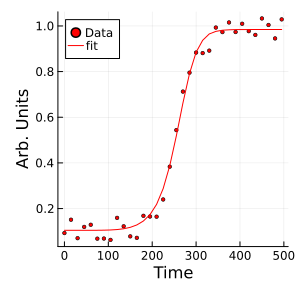

In [67]:
results_ms = Kinbiont.ODE_Model_selection(
    data_OD,
    "test", 
    "test_model_selection",
    list_of_models,
    list_guess;
    multistart = true,
    lb_param_array = list_lb,
    ub_param_array = list_ub  
)

Plots.scatter(data_OD[1,:],data_OD[2,:], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],color=:red,markersize =2 ,size = (300,300))
Plots.plot!(results_ms[4],results_ms[3], xlabel="Time", ylabel="Arb. Units", label=["fit " nothing],color=:red,markersize =2 ,size = (300,300))

The results of the model selection process are stored in the ```results_ms``` variable.

### ODE segmentation
For a single kinetics it is possible to run the segmentaion in two different ways. A manual selection of the change points or a using a change points detection algorithm to find them.

First of all we generate a synthetic daset composed by more than one model  (skip this part if you import a real dataset in the data variable).

In [68]:
#First segment ODE

model = "logistic"
n_start =[0.1]
tstart =0.0

tmax = 0100.0
delta_t=2.0
param_of_ode= [0.1,0.2]

sim_1 = Kinbiont.ODE_sim(model, #string of the model
    n_start, # starting condition
    tstart, # start time of the sim
    tmax, # final time of the sim
    delta_t, # delta t for poisson approx
    param_of_ode # parameters of the ODE model
)

sol_1 =reduce(vcat,sim_1)

# second segment ODE


model = "logistic"
n_start =[sol_1[end]]
tstart =100.0
tmax = 0200.0
delta_t=2.0
param_of_ode= [0.2,0.5]


sim_2= Kinbiont.ODE_sim(model, #string of the model
    n_start, # starting condition
    tstart, # start time of the sim
    tmax, # final time of the sim
    delta_t, # delta t for poisson approx
    param_of_ode # parameters of the ODE model
)

sol_2 =reduce(vcat,sim_2)
# third segment ODE


model = "logistic"
n_start =[sol_2[end]]
tstart =200.0
tmax = 0300.0
delta_t=2.0
param_of_ode= [0.1,0.9]

sim_3= Kinbiont.ODE_sim(model, #string of the model
    n_start, # starting condition
    tstart, # start time of the sim
    tmax, # final time of the sim
    delta_t, # delta t for poisson approx
    param_of_ode # parameters of the ODE model
)

sol_3 =reduce(vcat,sim_3)
times_sim =vcat(sim_1.t,sim_2.t)
times_sim =vcat(times_sim,sim_3.t)

# binding the simulatios
sol_sim =vcat(sol_1,sol_2)
sol_sim =vcat(sol_sim,sol_3)


Plots.scatter(times_sim,sol_sim, xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],  color=:blue, size = (300,300))



data_OD_seg = Matrix(transpose(hcat(times_sim,sol_sim)))

# Adding uniform noise to the dataset
noise_uniform = rand(Uniform(-0.01, 0.01), length(sol_sim))
data_OD_seg = Matrix(transpose(hcat(times_sim, sol_sim)))
data_OD_seg[2, :] = data_OD_seg[2, :] .+ noise_uniform

153-element Vector{Float64}:
 0.10238489508128859
 0.11264533755210175
 0.12625568869051962
 0.1380573214388351
 0.12835125252138863
 0.14517868996733801
 0.14418204970817955
 0.16295487364591643
 0.16863795384200841
 0.18047602404162535
 ⋮
 0.8938887821611587
 0.8957235125327885
 0.8999273056769175
 0.8953349704523078
 0.8937930027925501
 0.9001306213560348
 0.8902848805174297
 0.8903183934673486
 0.8975255671619795

Then we generate the list of models that will be used and their parameters's lower/upper bounds:

In [69]:
ub_exp = [0.1]
lb_exp = [-0.01]
p1_g = lb_exp .+(ub_exp.-lb_exp)./2
ub_logistic = [0.9, 5.0]
lb_logistic = [0.0001, 0.001]
p2_g = lb_logistic .+ (ub_logistic.-lb_logistic)./2

ub_hpm = [0.1, 20.0, 50.001]
lb_hpm = [0.0001, 0.000001, 0.001]
p3_g = lb_hpm .+(ub_hpm.-lb_hpm)./2


list_of_models = ["exponential",  "logistic","HPM"]
list_ub_param = [ub_exp,ub_logistic, ub_hpm]
list_lb_param = [lb_exp, lb_logistic,lb_hpm]
list_g = [p1_g, p2_g, p3_g]


3-element Vector{Vector{Float64}}:
 [0.045]
 [0.45005, 2.5004999999999997]
 [0.050050000000000004, 10.000000499999999, 25.001]

First, we fit giving to Kinbiont the list of change points:

┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 58.0, 60.0, 62.0, 64.0, 66.0, 68.0, 70.0, 72.0, 74.0, 76.0, 78.0, 80.0, 82.0, 84.0, 86.0, 88.0, 90.0, 92.0, 94.0, 96.0, 98.0, 100.0, 100.0]
└ @ Interpolations C:\Users\fabri\.julia\packages\Interpolations\y4lLj\src\gridded\gridded.jl:77
┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 2

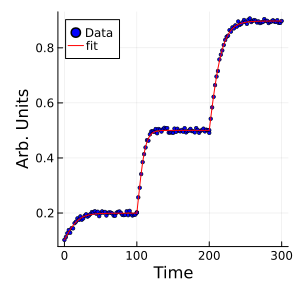

In [71]:
cdp_list = [100.0,200.0]
seg_fitting = Kinbiont.selection_ODE_fixed_intervals(
    data_OD_seg, # dataset first row times second row OD
    "test", # name of the well
    "", #label of the experiment
    list_of_models, #  models to use
    list_g,
    cdp_list;
    lb_param_array = list_lb_param,
    ub_param_array = list_ub_param,
)
Plots.scatter(data_OD_seg[1, :], data_OD_seg[2, :], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing], color=:blue, markersize=2, size=(300, 300))
Plots.plot!(seg_fitting[3], seg_fitting[4], xlabel="Time", ylabel="Arb. Units", label=["fit " nothing], color=:red, markersize=2, size=(300, 300))

In alternative, if the change points are not known we can run a cpd algorithm and perfom the fitting with :

In [45]:
n_change_points =2
seg_fitting = Kinbiont.segmentation_ODE(
   data_OD_seg, # dataset first row times second row OD
    "test", # name of the well
    "", #label of the experiment
    list_of_models, #  models to use
    list_g,
    n_change_points;
    lb_param_array = list_lb_param,
    ub_param_array = list_ub_param,
    detect_number_cpd=true,
    fixed_cpd=false,
)


changing the method of smoothing to lowess


┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107


changing the method of smoothing to lowess


┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107


changing the method of smoothing to lowess


┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107


changing the method of smoothing to lowess
changing the method of smoothing to lowess
changing the method of smoothing to lowess


┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107


changing the method of smoothing to lowess


┌ Warning: Unrecognized stop reason: Too many steps (101) without any function evaluations (probably search has converged). Defaulting to ReturnCode.Default.
└ @ Optimization C:\Users\fabri\.julia\packages\Optimization\EmxXu\src\utils.jl:107


("ODE_segmentation", Vector{Any}[["", "test", "logistic", 0.104345812713987, 0.20393316196268219, 0.04019720822219619, 0.041059087846682184, 0.00012224436801496288, 1], ["", "test", "logistic", 0.23917401329761795, 0.5074074694169018, 0.06781064751827628, 0.060486619360529646, 0.000564863753729065, 2], ["", "test", "logistic", 0.16502258317738164, 0.8939682431178245, 0.03832854099670098, 0.030462223683836328, 0.0003406442003111871, 3]], [0.09447937571293527, 0.10510467050045687, 0.11566218480629302, 0.1259289044850174, 0.13570588382204848, 0.14483253804335194, 0.15319471468916052, 0.16072685063626652, 0.16740770571040564, 0.17325215603421545  …  0.8939666792338037, 0.8939689506251562, 0.8939699290631479, 0.893969554475029, 0.8939680933859036, 0.8939661389187293, 0.8939646107943177, 0.8939647407410939, 0.8939657254814326, 0.8939664329989571], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0  …  282.0, 284.0, 286.0, 288.0, 290.0, 292.0, 294.0, 296.0, 298.0, 300.0], [102.0, 206.0], 

### Fitting NL Models
With Kinbiont it is possible to fit any non-linear model this can be done by calling the function ```NL_model_selection``` in different ways.


First we declare upper and lower bound and the model (note that in this case we use array of array because the input can be more than one model)

In [73]:
nl_model = ["NL_Richards"]
p_guess = [[1.0,1.0,0.01,300.0]]
lb_nl =[[0.01,0.01,0.000001,00.01]]
ub_nl =p_guess.*3

1-element Vector{Vector{Float64}}:
 [3.0, 3.0, 0.03, 900.0]

To perform a single fit on a time series (i.e., ```data_OD```) then we run the following:

In [74]:
nl_fit = Kinbiont.NL_model_selection(data_OD, # dataset first row times second row OD
"test", 
"test_model_selection",
nl_model, #  model to use
p_guess;
)

┌ Warning: The used optimization method requires box bounds, Kinbiont.jl will use upper bounds that are 10 times the guess
│              and lower bounds that are 10 times lower the guess.
│              This choice can be suboptimal. Note that the Kinbiont.jl default optimizer requires box bounds to guaranteed a Real N(t) and positive parameters.
│              To avoid to specify the bounds use you can use an optimizer that do not require it, e.g., `optimizer = NOMADOpt()`. 
│              Note that numerical instabilities may occur.
│              
└ @ Kinbiont C:\Users\fabri\.julia\packages\Kinbiont\JBDLc\src\functions.jl:916


("NL_model_selection", Any["test_model_selection", "test", "NL_Richards", 1.0059240238713174, 9.999999965842632, 0.07219444196764825, 318.7848086679925, 0.007219444215408501, 0.020160663791835388, 0.057751523371649564], [0.07999420305657039, 0.08914335761551112, 0.09933892586337287, 0.11070058897870297, 0.12336171639981129, 0.1374709313834143, 0.15319385560936252, 0.17071505328397096, 0.19024019747533183, 0.2119984838220379  …  0.9652977547235164, 0.9900204939423594, 1.0002214405086212, 1.0039529067363433, 1.005251818156719, 1.0056958567531484, 1.005846701232887, 1.0058978346019425, 1.005915155174744, 1.0059210207767497], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0], Any["AIC" -88.95458874074166], 0.057751523371649564)

The user can specify any parameter of the optimizer, for the bound in this case it is done via:

In [75]:
nl_fit =  Kinbiont.NL_model_selection(data_OD, # dataset first row times second row OD
    "test", 
    "test_model_selection",
    nl_model, #  model to use
    p_guess;
    lb_param_array =lb_nl,
    ub_param_array = ub_nl,
    maxiters=2000000,
    abstol=0.00001,
)

("NL_model_selection", Any["test_model_selection", "test", "NL_Richards", 1.1698322700794415, 2.9977981163456655, 0.022119093016703516, 315.2990211840541, 0.007371386290018171, 0.020160663791835388, 0.061271540646202924], [0.07919129945068593, 0.0884557281751892, 0.09880239226767948, 0.11035682956951161, 0.12325864816805553, 0.13766282872931043, 0.15374098964372723, 0.17168250748653618, 0.19169531805104018, 0.21400612081992393  …  0.9111416192595596, 0.961476562741868, 1.0054740560113153, 1.0426069935954372, 1.0729548106255498, 1.097069675955715, 1.1157851779035912, 1.1300356168565366, 1.1407245795709309, 1.148650175621239], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0], Any["AIC" -86.94295345037568], 0.061271540646202924)

### NL Sensitivity Analysis

As for the ODE model, also for the NL fit it is possible to perform a sensitivity analysis with respect to the initial starting guess of the parameters, in this case we just use ```method_of_fitting= "Morris_sensitivity"``` and nrep as the number of Morris steps

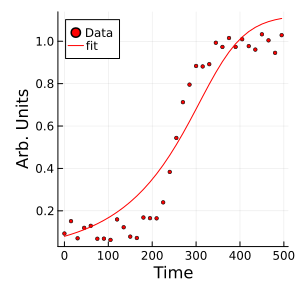

In [76]:
nl_fit =  Kinbiont.NL_model_selection(data_OD, # dataset first row times second row OD
"test", 
"test_model_selection",
nl_model, #  model to use
p_guess;
nrep =30,
method_of_fitting ="Morris_sensitivity",
multistart = true,
lb_param_array = lb_nl,
ub_param_array = ub_nl
)

Plots.scatter(data_OD[1,:],data_OD[2,:], xlabel="Time", ylabel="Arb. Units", label=["Data " nothing],color=:red,markersize =2 ,size = (300,300))
Plots.plot!(nl_fit[4],nl_fit[3], xlabel="Time", ylabel="Arb. Units", label=["fit " nothing],color=:red,markersize =2 ,size = (300,300))

### NL Model Selection
To perform model selection we just specify an array with the list of all the used models:


In [79]:

nl_ub_1 =  [2.0001 , 10.00000001, 500.00]
nl_lb_1 =  [0.0001 , 0.00000001, 0.00 ]
p1_guess = nl_lb_1 .+ (nl_ub_1.-nl_lb_1)./2

nl_ub_2 =  [2.0001 , 10.00000001, 5.00,5.0]
nl_lb_2 =  [0.0001 , 0.00000001, 0.00,0.0 ]
p2_guess = nl_lb_2 .+ (nl_ub_2.-nl_lb_2)./2

nl_ub_3 =  [2.0001 , 10.00000001]
nl_lb_3 =  [0.0001 , 0.00000001]
p3_guess = nl_lb_3 .+ (nl_ub_3.-nl_lb_3)./2

nl_ub_4 =  [2.0001 , 10.00000001, 500.00]
nl_lb_4 =  [0.0001 , 0.00000001, 0.00 ]
p4_guess = nl_lb_4 .+ (nl_ub_4.-nl_lb_4)./2

list_models_f = ["NL_Gompertz","NL_Bertalanffy","NL_exponential","NL_Gompertz"]
list_lb =[nl_lb_1,nl_lb_2,nl_lb_3,nl_lb_4]
list_ub = [nl_ub_1,nl_ub_2,nl_ub_3,nl_ub_4]
list_guess = [p1_guess,p2_guess,p3_guess,  p4_guess]

4-element Vector{Vector{Float64}}:
 [1.0001, 5.00000001, 250.0]
 [1.0001, 5.00000001, 2.5, 2.5]
 [1.0001, 5.00000001]
 [1.0001, 5.00000001, 250.0]

and the we perform the fit:

In [80]:
results_ms = Kinbiont.NL_model_selection(
    data_OD,
    "test", 
    "test_model_selection",
    list_models_f,
    list_guess;
    lb_param_array = list_lb,
    ub_param_array = list_ub  
)

("NL_model_selection", Any["test_model_selection", "test", "NL_Bertalanffy", 0.11556496779571648, 1.0328795415172909, 0.02363217805362005, 0.0030182891437109715, 0.01939675004005678, 0.020160663791835388, 0.022236097523014822], [0.11556496779571648, 0.11556496779571648, 0.11556496779571648, 0.11556496779571648, 0.11556496779571648, 0.11556496779571648, 0.11556496779571648, 0.1155649677959656, 0.11556496962872748, 0.11556579025157315  …  0.9735110076349139, 0.9908176344056697, 1.003166173393633, 1.01193264142478, 1.0181341055463449, 1.0225101696243308, 1.0255927562035148, 1.0277615347999554, 1.0292860864712996, 1.0303571306708648], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0], Any["AIC" -80.80808214465863 … -83.28882404993871 -80.8080821447124], 0.022236097523014822)

### NL segmentation

As the ODE case, for NL segmentation we can perform a segmente fit with manual selection of the change points or a using a change points detection algorithm to find them.
Note that in the case of the NL fit, the fit of the segment goes backward and since it is not possible to specificy the bounduary condition of the fit the user can force the optimization problem to mantain the continuty between segment with the parameter  ```penality_CI=8.0```. 

we specify the list of used models and parameters bounds:

In [83]:
ub_1 = [0.3 , 0.1]
lb_1 = [0.01 , -0.01]
p1_guess = lb_1 .+(ub_1.-lb_1)./2

ub_2 = [1.9, 0.1,500.0]
lb_2 = [0.0001,0.001 ,0.001]
p2_guess = lb_2 .+(ub_2.-lb_2)./2

ub_3 = [0.1, 1.1, 500.0]
lb_3 = [0.0001, 0.000001, 0.001]
p3_guess = lb_3 .+(ub_3.-lb_3)./2


list_of_models_nl = ["NL_exponential",  "NL_logistic","NL_Gompertz"]
list_ub_param = [ub_1,ub_2, ub_3]
list_lb_param = [lb_1, lb_2,lb_3]
list_guess = [p1_guess, p2_guess, p3_guess]

3-element Vector{Vector{Float64}}:
 [0.155, 0.045]
 [0.95005, 0.0505, 250.00050000000002]
 [0.050050000000000004, 0.5500005000000001, 250.00050000000002]

As before we specify the intervals of the segment and we proceed to fit:

In [84]:
cdp_list = [100.0, 200.0]

seg_fitting = Kinbiont.selection_NL_fixed_interval(
   data_OD_seg, # dataset first row times second row OD
    "test", # name of the well
    "", #label of the experiment
    list_of_models_nl, #  models to use
    list_guess,
    cdp_list;
    lb_param_array = list_lb_param,
    ub_param_array = list_ub_param,
    pt_smooth_derivative = 3
)

(Vector{Any}[["", "test", "NL_logistic", 0.8572593704068998, 0.021571270628195305, 0.02791788294864569, 0.0032182368927162926, 0.03429718230410537, 9.932245522073582e-5, 3], ["", "test", "NL_exponential", 0.15579012052812688, 0.007802849219246715, 0.0078028492192469545, 0.07124808973925593, 0.0002457564045835124, 2], ["", "test", "NL_exponential", 0.11095938861919591, 0.011129479283070743, 0.011129479283070965, 0.05239248333051393, 6.927948852058497e-5, 1]], [0.11095938861919591, 0.11345692218264405, 0.11601067157404665, 0.11862190212947724, 0.1212919076658738, 0.12402201112210143, 0.1268135652144444, 0.12966795310685209, 0.13258658909627172, 0.1355709193134063  …  0.8447916845024643, 0.8454594295769227, 0.8460918842810192, 0.846690864339184, 0.847258097219643, 0.8477952258786451, 0.8483038124054286, 0.8487853415633256, 0.8492412242235535, 0.8496728006892704], [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0  …  282.0, 284.0, 286.0, 288.0, 290.0, 292.0, 294.0, 296.0, 298.0, 300.0

Another option could be to  run a cpd algorithm and perfom the fitting:

In [86]:
n_change_points = 2

seg_fitting = Kinbiont.segmentation_NL(
   data_OD, # dataset first row times second row OD
    "test", # name of the well
    "", #label of the experiment
    list_of_models_nl, #  models to use
    list_guess,
    2;
    detect_number_cpd=true,
    fixed_cpd=false,
    lb_param_array = list_lb_param,
    ub_param_array = list_ub_param,
    beta_smoothing_ms=2.0, #  parameter of the AIC penality
    correction_AIC=true,
)

("NL_segmentation", Vector{Any}[["", "test", "NL_exponential", 0.23623597077829342, 0.003278733684490891, 0.0032787336844909074, 0.018026867756468275, 0.0018169489968838728, 2], ["", "test", "NL_exponential", 0.09234598176057626, 0.0048419794704065225, 0.004841979470406557, 0.06209721937520461, 0.00045992120163651994, 1]], [0.09234598176057626, 0.09930261318528381, 0.10678330337093128, 0.11482753084788075, 0.12347774815337229, 0.1327796058701808, 0.14278219354261076, 0.15353829874123728, 0.16510468564357914, 0.17754239460088347  …  0.7690648590974061, 0.8078337749988439, 0.8485570499148607, 0.891333203988954, 0.9362657238107058, 0.9834633127766306, 1.0330401540718295, 1.0851161869086734, 1.1398173966908034, 1.1972761198044346], [0.0, 15.0, 30.0, 45.0, 60.0, 75.0, 90.0, 105.0, 120.0, 135.0  …  360.0, 375.0, 390.0, 405.0, 420.0, 435.0, 450.0, 465.0, 480.0, 495.0], [240.0])

### Fitting a ODEs System

This example demonstrates how to fit an Ordinary Differential Equations (ODEs) syste using Kinbiont. The system models interactions between four variables, and we aim to estimate its parameters from noisy simulated data.

First we define a custom model (if you want to use an harcoded model just put the corresponding sting in the model field for the simulation and the fit).
The system consists of:
- **u1**: A reactant influenced by u4.
- **u2**: An intermediate product.
- **u3**: A final product.
- **u4**: A resource that decreases as the reaction proceeds.

The ODE system is defined as:

In [87]:

function model_1(du, u, param, t)
    du[1] = param[1] * u[1] * u[4]                  # Reactant conversion
    du[2] = param[4] * du[1] - param[3] * u[2] - param[2] * u[2]  # Intermediate balance
    du[3] = param[3] * u[2] - param[2] * u[3]       # Final product formation
    du[4] = -du[1]                                  # Resource consumption
end

model_1 (generic function with 1 method)

We define initial conditions, true parameters,and the bounds of the fit:

In [88]:
u0 = [0.1, 0.0, 0.0, 1.0]  # Initial conditions for [u1, u2, u3, u4]
param = [0.1, 0.01, 0.5, 0.42]  # True parameter values

lb1 = [0.01, 0.0001, 0.0, 0.01]  # Lower bounds
ub1 = [0.2, 0.3, 1.1, 1.0]       # Upper bounds
param_guess = lb1 .+ (ub1 .- lb1) ./ 2  # Initial parameter guess

4-element Vector{Float64}:
 0.105
 0.15005
 0.55
 0.505

We simulate the data

In [90]:
Simulation = ODEs_system_sim(
    model_1, # ODE function
    u0,      # Initial conditions
    0.0,     # Start time
    50.0,    # End time
    1.0,     # Time step for Poisson approximation
    param    # True parameters
);

We add some uniform noise

In [91]:
sol_time = reduce(hcat, Simulation.t)
sol_t = reduce(hcat, Simulation.u)

# Adding uniform random noise
sol_t_noise = [sol_t[i, :] .+ rand(Uniform(-0.05, 0.05), size(sol_t)[2]) for i in 1:size(sol_t)[1]]
sol_t_noise = permutedims(reduce(hcat, sol_t_noise))

data = vcat(sol_time, sol_t_noise)

5×51 Matrix{Float64}:
 0.0          1.0        2.0         …  48.0        49.0        50.0
 0.149505     0.108965   0.12259         1.02072     1.06825     1.06819
 0.0482281    0.033413   0.0428402       0.0429495  -0.0329123   0.00130533
 0.00585169  -0.0186246  0.00964944      0.26158     0.265125    0.256675
 1.02273      0.943689   1.02622         0.0403749   0.0693648   0.0185661

We plot the data with noise:

In [ ]:
scatter(data[1, :], data[2, :], label="u1")
scatter!(data[1, :], data[3, :], label="u2")
scatter!(data[1, :], data[4, :], label="u3")
display(scatter!(data[1, :], data[5, :], label="u4"))

We Fit the Model Using Kinbiont

In [94]:
fit = fit_ODEs_System(
    data,
    "test",     # Label for dataset
    model_1,    # ODE model
    param_guess, # Initial parameter guess
    u0;         # Initial conditions
    lb=lb1,     # Lower bounds
    ub=ub1      # Upper bounds
);

We plot the fitted model

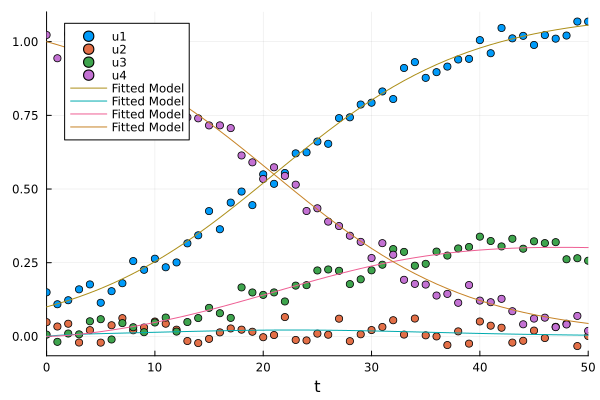

In [95]:
plot!(fit[3], label="Fitted Model")

### Fitting reaction network


We define a **Michaelis-Menten enzyme kinetics** reaction network using Catalyst (https://docs.sciml.ai/Catalyst/stable/) :

In [96]:
# Define initial conditions
u0 = [:S => 301, :E => 100, :SE => 0, :P => 0]

# Define kinetic parameters
ps = [:kB => 0.00166, :kD => 0.0001, :kP => 0.1]

# Define the Michaelis-Menten reaction network
model_Michaelis_Menten = @reaction_network begin
    kB, S + E --> SE
    kD, SE --> S + E
    kP, SE --> P + E
end

Model ##ReactionSystem#255
States (4):
  S(t)
  E(t)
  SE(t)
  P(t)
Parameters (3):
  kB
  kD
  kP

We simulate the reaction system over a time range (`t=0` to `t=10`) using Kinbiont's reaction network simulation function:

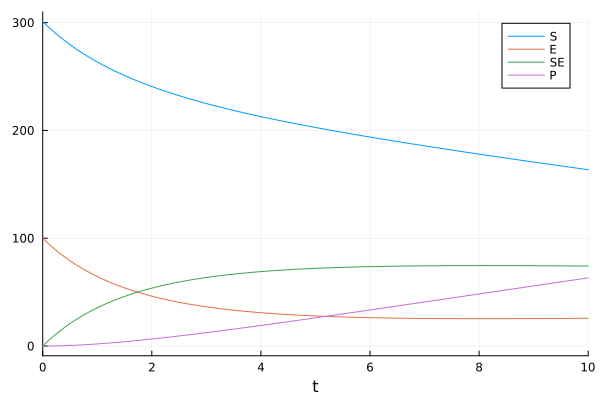

In [97]:
# Run simulation
Simulation = Kinbiont.Kinbiont_Reaction_network_sim(
    "Michaelis_Menten",
    u0,
    0.0, 10.0, 0.1, # Start time, end time, step size
    ps
)

# Plot the simulation results
plot(Simulation)

We introduce synthetic noise to the simulated data to mimic experimental uncertainty:

In [104]:
# Extract time-series data from the simulation
sol_time = reduce(hcat, Simulation.t)
sol_t = reduce(hcat, Simulation.u)

# Add noise to the dataset
noise = rand(Uniform(-0.01, 0.05), size(sol_t))
sol_t_noise = sol_t .+ noise
data = vcat(sol_time, sol_t_noise)

5×101 Matrix{Float64}:
   0.0          0.1          0.2      …    9.8       9.9      10.0
 301.007      296.183      291.651       164.994   164.308   163.602
  99.9933      95.2205      90.7505       25.7621   25.7684   25.8472
   0.0117773    4.83362      9.32406      74.3053   74.2562   74.1815
   0.0412196    0.0486538    0.13521      61.7504   62.5508   63.2806

We plot the data

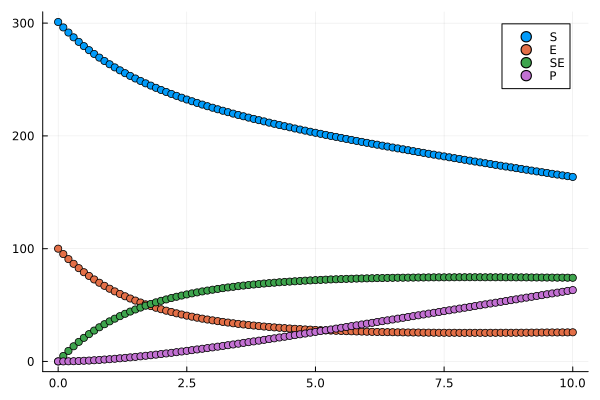

In [105]:
# Scatter plot of noisy data
scatter(data[1, :], data[2, :], label="S")
scatter!(data[1, :], data[3, :], label="E")
scatter!(data[1, :], data[4, :], label="SE")
scatter!(data[1, :], data[5, :], label="P")

We use `RN_fit` to estimate the reaction parameters from the noisy dataset:

┌ Warning: The used optimization method requires box bounds, Kinbiont.jl will use upper bounds that are 10 times the guess
│              and lower bounds that are 10 times lower the guess.
│              This choice can be suboptimal. Note that the Kinbiont.jl default optimizer requires box bounds to guaranteed a Real N(t) and positive parameters.
│              To avoid to specify the bounds use you can use an optimizer that do not require it, e.g., `optimizer = NOMADOpt()`. 
│              Note that numerical instabilities may occur.
│              
└ @ Kinbiont C:\Users\fabri\.julia\packages\Kinbiont\JBDLc\src\Reaction_Net_functions.jl:40


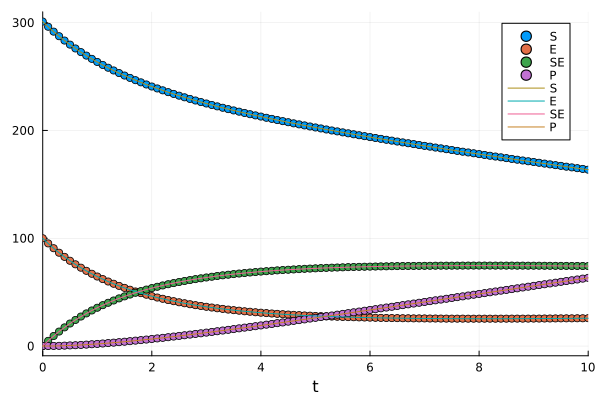

In [106]:
# Fit the model to noisy data
fit = RN_fit(data, model_Michaelis_Menten, u0, ps)

# Overlay the fitted model on the original plot
plot!(fit[4])

### Fitting a cybernetic models



We define a Kinbiont Cybernetic Model with specific parameters:

In [2]:
import Kinbiont.Kinbiont_Cybernetic_Model

# we define a dynamic resource allocation rule that switches to a substrate if its protein concentration exceeds a threshold and the most abundant

function threshold_switching_rule(a, b, V_S, k_S, Y_S, P, S, cost, protein_thresholds)
    n = length(S)
    alloc = zeros(n)
    # Sort substrates by descending utilization rate (V_S)
    sorted_indices = sortperm(V_S, rev=true)

    for i in sorted_indices
        if S[i] > protein_thresholds
            alloc[i] = 1.0    # Allocate all resources to this substrate
            break
        end
    end

    # If no substrate is above the threshold, fallback to equal allocation
    if sum(alloc) == 0
        alloc .= 1.0 / n
    end

    return alloc
end
# Define the Cybernetic Model
model = Kinbiont_Cybernetic_Model(
    Bio_mass_conc = 1.01,  # Initial biomass concentration
    Substrate_concentrations = [5.0, 5.0],  # Concentrations of 2 substrates
    Protein_concentrations = [0.0, 0.0],  # Initial protein concentrations
    allocation_rule = threshold_switching_rule,  # Dynamic resource allocation rule
    reaction = nothing,  # No specific reaction function provided
    cost = nothing,  # No cost function
    protein_thresholds = 0.01,  # Protein activation threshold
    a = [0.1, 0.4],  # Synthesis rate constants for proteins
    b = [0.00001, 0.000001],  # Degradation constants for proteins
    V_S = [0.7, 0.1],  # Substrate utilization rates
    k_S = [0.1, 0.11],  # Saturation constants for substrates
    Y_S = [0.07, 0.11]  # Yield coefficients for biomass per substrate
)

Kinbiont_Cybernetic_Model(1.01, [5.0, 5.0], [0.0, 0.0], threshold_switching_rule, nothing, Union{Nothing, Float64}[0.1, 0.4], Union{Nothing, Float64}[1.0e-5, 1.0e-6], Union{Nothing, Float64}[0.7, 0.1], Union{Nothing, Float64}[0.1, 0.11], Union{Nothing, Float64}[0.07, 0.11], nothing, 0.01)

We simulate the model over time (from `t=0` to `t=100`) using the `Tsit5` solver:

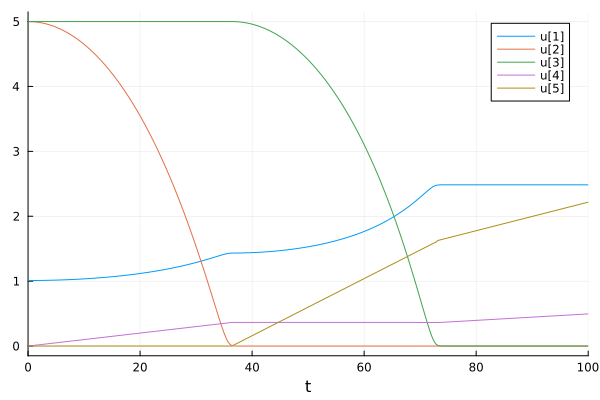

In [3]:
# Simulate the model
simulation = Kinbiont_Cybernetic_Model_simulation(model, 0.0, 100.0, 0.1)

# Plot the results
plot(simulation)

We extract the simulation data (biomass, substrate, and protein concentrations over time) for fitting:

In [4]:
# Extract time-series data from the simulation

data_to_fit = hcat(simulation.t, reduce(hcat, simulation.u)[1,:])
data_to_fit = hcat(data_to_fit, reduce(hcat, simulation.u)[2,:])
data_to_fit = hcat(data_to_fit, reduce(hcat, simulation.u)[3,:])
data_to_fit = hcat(data_to_fit, reduce(hcat, simulation.u)[4,:])
data_to_fit = hcat(data_to_fit, reduce(hcat, simulation.u)[5,:])
data_to_fit = permutedims(data_to_fit)  # Convert to column-major order

6×1001 Matrix{Float64}:
 0.0   0.1          0.2      0.3      …  99.9          100.0
 1.01  1.01         1.01001  1.01002      2.4842         2.4842
 5.0   4.99997      4.99986  4.99969      1.46091e-7     9.72203e-8
 5.0   5.0          5.0      5.0          6.64845e-42    4.059e-42
 0.0   0.000999999  0.002    0.003        0.49497        0.495469
 0.0   0.0          0.0      0.0      …   2.21492        2.21712

We define a new model where some parameters (`a`, `V_S`)  are unknown and need to be fitted, to do that we put them to nothing in the data struct:

In [5]:
# Define a new model with unknown parameters
model_fit = Kinbiont_Cybernetic_Model(
    Bio_mass_conc = 1.01,  # Initial biomass concentration
    Substrate_concentrations = [2.0, 5.0],  # Initial substrate concentrations
    Protein_concentrations = [0.0, 0.0],  # No initial protein concentrations
    allocation_rule = threshold_switching_rule,  # Different allocation rule
    reaction = nothing,  # No specific reaction function
    cost = nothing,  # No cost function
    protein_thresholds = 0.01,  # Protein activation threshold
    a = [nothing, 0.1],  # One synthesis rate is unknown
    b = [0.00001, 0.000001],  # Known degradation constants
    V_S = [nothing, 0.4],  # One substrate utilization rate is unknown
    k_S = [0.1, 0.11],  # Saturation constants
    Y_S = [0.07, 0.11]  # Yield coefficients
)

Kinbiont_Cybernetic_Model(1.01, [2.0, 5.0], [0.0, 0.0], threshold_switching_rule, nothing, Union{Nothing, Float64}[nothing, 0.1], Union{Nothing, Float64}[1.0e-5, 1.0e-6], Union{Nothing, Float64}[nothing, 0.4], Union{Nothing, Float64}[0.1, 0.11], Union{Nothing, Float64}[0.07, 0.11], nothing, 0.01)

Using `fit_Cybernetic_models`, we fit the model parameters to experimental data:

In [6]:
# Fit the model to experimental data
results = fit_Cybernetic_models(
    data_to_fit,  # Experimental data
    "test",  # Dataset name
    model_fit,  # Model with unknown parameters
    [0.01, 0.1];  # Initial guesses for unknown parameters (a and V_S)
    set_of_equations_to_fit = nothing  # No additional constraints
)

┌ Warning: The used optimization method requires box bounds, Kinbiont.jl will use upper bounds that are 10 times the guess
│              and lower bounds that are 10 times lower the guess.
│              This choice can be suboptimal. Note that the Kinbiont.jl default optimizer requires box bounds to guaranteed a Real N(t) and positive parameters.
│              To avoid to specify the bounds use you can use an optimizer that do not require it, e.g., `optimizer = NOMADOpt()`. 
│              Note that numerical instabilities may occur.
│              
└ @ Kinbiont C:\Users\fabri\.julia\packages\Kinbiont\JBDLc\src\Generalized_Cybernetic_Models.jl:484


(Kinbiont_Cybernetic_Model(1.01, [2.0, 5.0], [0.0, 0.0], threshold_switching_rule, nothing, Union{Nothing, Float64}[nothing, 0.1], Union{Nothing, Float64}[1.0e-5, 1.0e-6], Union{Nothing, Float64}[nothing, 0.4], Union{Nothing, Float64}[0.1, 0.11], Union{Nothing, Float64}[0.07, 0.11], nothing, 0.01), [0.09565454092695314, 0.4000000062673661], 2.7683717690847347)

In [ ]:
# Fitted parameters
results[2]

2-element Vector{Float64}:
 0.09565454092695314
 0.4000000062673661